## Data Generation

In [2]:
from models import *
from data_generation import *
from experiments import *
import pandas as pd
import math
import matplotlib.pyplot as plt

### Linear Dataset

This simulate a very simple scenario in which the hidden confounder is one dimensional with distribution
$$
Z \sim \mathcal{N}(0,1)
$$
and the proxies from which we study the confounder
$$
X_j \sim \mathcal{N}(a_j z,\sigma_X^2)\,,\quad a_j \sim \mathcal{U}_{[-10,10]}
$$
finally the treatment and the outcome are
$$
T|Z=z \sim \text{Bernoulli}(\sigma(\beta z))
$$
$$
Y|Z=z,T=t \sim \mathcal{N}(z + t, \sigma_Y^2)
$$

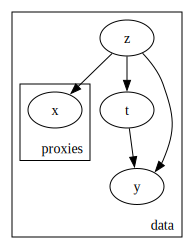

In [3]:
import pyro
import torch
import pyro.distributions as dist

def model(x_obs=None, t_obs=None, y_obs=None, sigma_x=1.0, sigma_y=1.0, beta=2.0):
    N, P = x_obs.shape if x_obs is not None else (None, 5)  # Use 5 proxies if x not provided

    # ----- Fixed proxy coefficients -----
    a = pyro.param("a", dist.Uniform(-10., 10.).sample([P]), event_dim=0)  # [P]

    with pyro.plate("data", N):
        # Latent confounder
        z = pyro.sample("z", dist.Normal(0., 1.))  # [N]

        # Proxies X_j ~ N(a_j * z, sigma_x^2)
        with pyro.plate("proxies", P):
            mu_x = z.unsqueeze(-1) * a  # shape [N, P]
            pyro.sample("x", dist.Normal(mu_x, sigma_x), obs=x_obs)

        # Treatment T ~ Bernoulli(sigmoid(beta * z))
        logits_t = beta * z
        t = pyro.sample("t", dist.Bernoulli(logits=logits_t), obs=t_obs)

        # Outcome Y ~ N(z + t, sigma_y^2)
        if t_obs is not None:
            mu_y = z + t_obs
        else:
            mu_y = z + t 
        pyro.sample("y", dist.Normal(mu_y, sigma_y), obs=y_obs)

pyro.render_model(model, render_distributions=False, render_params=False)

In [4]:
num_proxies = 10

linear_dataset = synthetic_dataset_linear(
    n = 1000,
    beta = 1.0,
    num_proxies = num_proxies,
    shuffle_pct = 0.0,
    sigma_x = 1.0,
    sigma_y = 1.0,
    seed = 0
)
x = linear_dataset['x']
y = linear_dataset['y']
t = linear_dataset['t']
z = linear_dataset['z']
ite = linear_dataset['ite']

### Proxies Histograms

We expect:
$$\mathbb{E}[X_j] = \mathbb{E}[a_j Z] = a_j \mathbb{E}[Z]= a_j 0 = 0$$
$$Var(X_j)=\mathbb{E}[Var(X_j|Z)]+Var(\mathbb{E}[X_j|Z])= \sigma^2_X+Var(a_j Z)= \sigma^2_X + a_j^2 Var(Z)= \sigma^2_X + a_j^2$$

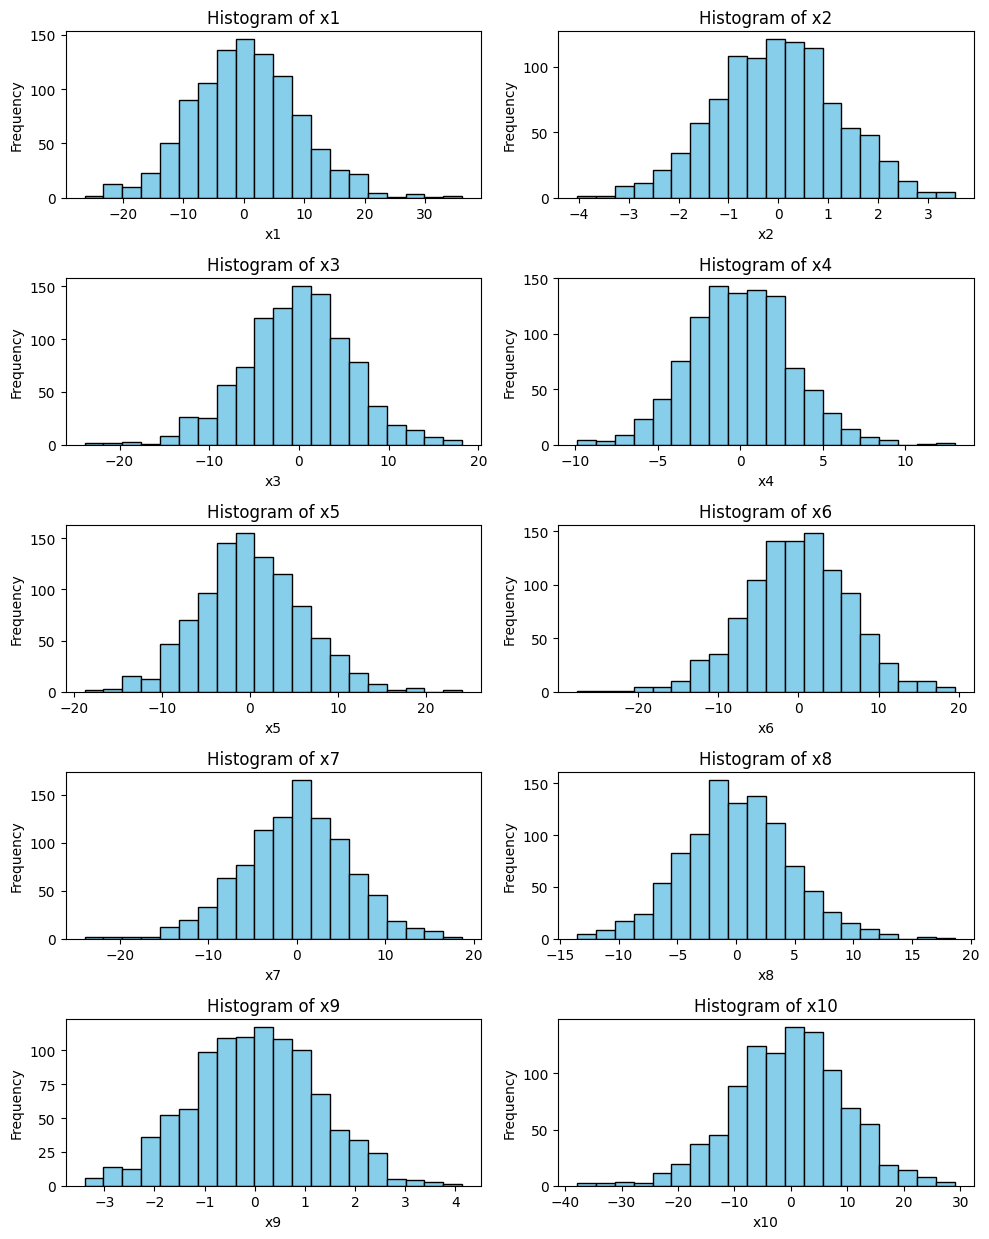

In [5]:
ncols = 2
nrows = math.ceil(num_proxies / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(10, 2.5 * nrows))
axes = axes.flatten()

for idx in range(num_proxies):
    ax = axes[idx]
    ax.hist(x[:, idx].numpy(), bins=20, color='skyblue', edgecolor='black')
    ax.set_title(f'Histogram of x{idx+1}')
    ax.set_xlabel(f'x{idx+1}')
    ax.set_ylabel('Frequency')

# Hide any unused subplots
for idx in range(num_proxies, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

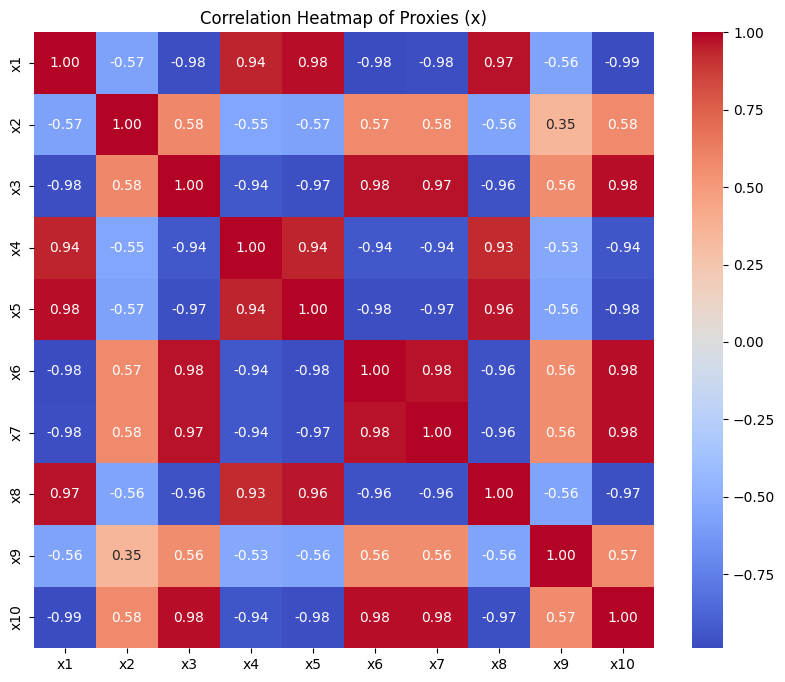

In [6]:
import seaborn as sns

# Convert x to a pandas DataFrame for correlation calculation
x_df = pd.DataFrame(x.numpy(), columns=[f'x{i+1}' for i in range(x.shape[1])])
corr_matrix = x_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Proxies (x)')
plt.show()

In [7]:
num_proxies = 10

linear_dataset = synthetic_dataset_linear(
    n = 1000,
    beta = 1.0,
    num_proxies = num_proxies,
    shuffle_pct = 0.5,
    sigma_x = 1.0,
    sigma_y = 1.0,
    seed = 0
)
x = linear_dataset['x']
y = linear_dataset['y']
t = linear_dataset['t']
z = linear_dataset['z']
ite = linear_dataset['ite']

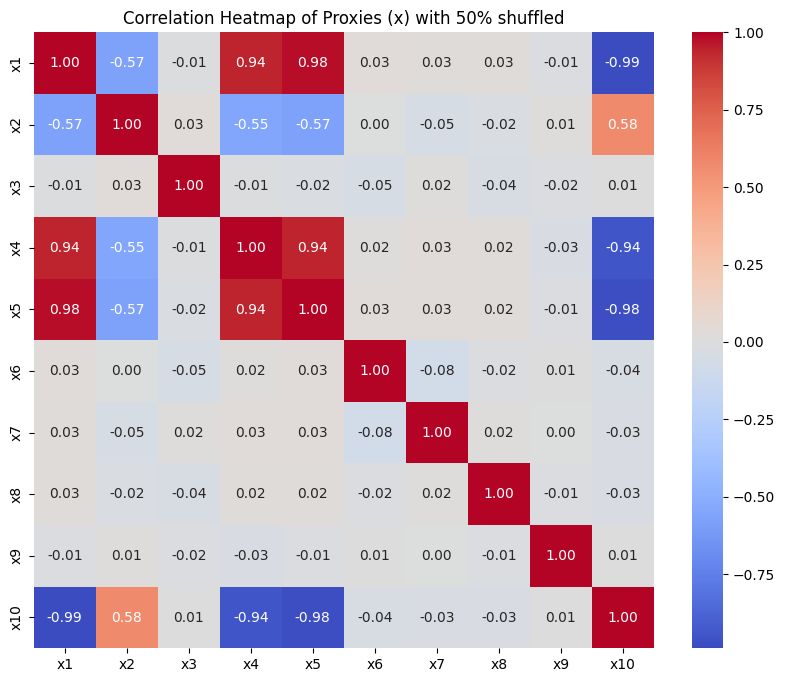

In [8]:
import seaborn as sns

# Convert x to a pandas DataFrame for correlation calculation
x_df = pd.DataFrame(x.numpy(), columns=[f'x{i+1}' for i in range(x.shape[1])])
corr_matrix = x_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Proxies (x) with 50% shuffled')
plt.show()

### Non Linear Dataset

Keeping the notation of the previous dataset:
$$
Z\sim\mathcal{N}(0,1)\quad \text{or} \\
Z\sim\frac12\mathcal{N}(-2,1)+\frac12\mathcal{N}(2,1)\quad \text{or} \\
Z \sim\text{Lognormal}(0,1)
$$

$$
X_1,...,X_d \sim \mathcal{N}(a\tanh(z),\Sigma)\quad a_j \sim \mathcal{U}_{[-1.5,1.5]} \quad \Sigma=\sigma_X^2[(1-\rho) I+\rho\mathbb{1} ^T]
$$

$$
T|Z\sim\text{Bernoulli}(\sigma(\beta z))
$$

$$
Y|Z,T\sim \mathcal{N}\left(\sin(z)+\frac12z+t\left(1+\frac12z\right),\sigma_Y^2\right)
$$

Depending on the value of $\rho$, the features $X$ are sampled from a multivariate normal distribution with either diagonal ($\rho = 0$) or non-diagonal ($\rho > 0$) covariance. That is, the features are conditionally independent given $Z$ when $\rho = 0$, and conditionally dependent when $\rho > 0$ due to correlated noise.

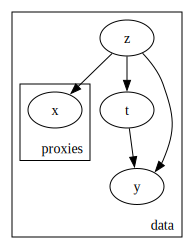

In [9]:
def nonlinear_latent_model(x=None, t=None, y=None, sigma_x=0.1, sigma_y=0.1, rho=0.0, beta=1.0):
    N, D = x.shape  # N samples, D proxies

    # Global a_j coefficients (assumed fixed per feature)
    a = pyro.param("a", dist.Uniform(-1.5, 1.5).sample([D]))  # shape [D]

    # Build covariance matrix Sigma = sigma_x² * [(1 - ρ)I + ρ * 11ᵀ]
    eye = torch.eye(D)
    ones = torch.ones((D, D))
    Sigma = sigma_x**2 * ((1 - rho) * eye + rho * ones)

    # Register Sigma as a constant buffer for efficiency
    L = torch.linalg.cholesky(Sigma)

    with pyro.plate("data", N):
        # Latent confounder
        z = pyro.sample("z", dist.Normal(0., 1.))  # [N]

        # Proxy features
        tanh_z = torch.tanh(z).unsqueeze(1)  # [N,1]
        mean_x = tanh_z * a  # [N,D]
        x = pyro.sample("x_obs", dist.MultivariateNormal(mean_x, scale_tril=L), obs=x)

        # Treatment
        logits_t = beta * z
        t = pyro.sample("t_obs", dist.Bernoulli(logits=logits_t), obs=t)

        # Outcome
        y_mean = torch.sin(z) + 0.5 * z + t * (1 + 0.5 * z)
        pyro.sample("y_obs", dist.Normal(y_mean, sigma_y), obs=y)

pyro.render_model(model, render_distributions=False, render_params=False)

In [10]:
num_proxies = 10

non_linear_dataset = synthetic_dataset_non_linear(
    n = 2000,
    beta = 2.0,
    num_proxies = 10,
    shuffle_pct = 0.0,
    prior_type = "gaussian",
    sigma_x = 1.0,
    sigma_y = 1.0,
    rho = 0.0,   
    seed = 0,
)

x = non_linear_dataset['x']
y = non_linear_dataset['y']
t = non_linear_dataset['t']
z = non_linear_dataset['z']
ite = non_linear_dataset['ite']

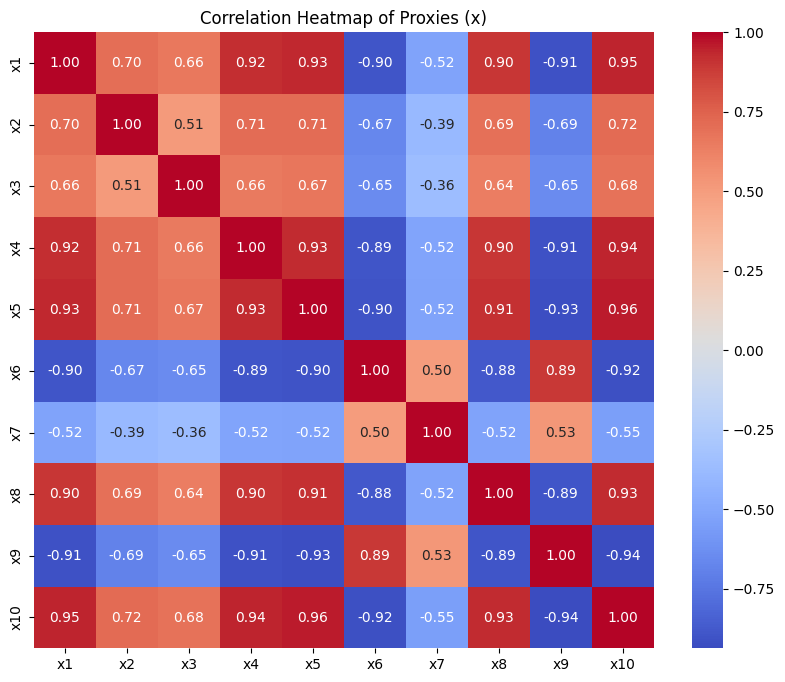

In [11]:
# Convert x to a pandas DataFrame for correlation calculation
x_df = pd.DataFrame(x.numpy(), columns=[f'x{i+1}' for i in range(x.shape[1])])
corr_matrix = x_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Proxies (x)')
plt.show()

Introducing correlation in the off diagonal terms $\rho=0.9$. This correlation is now not through $Z$ but just on the $X_j$ noise

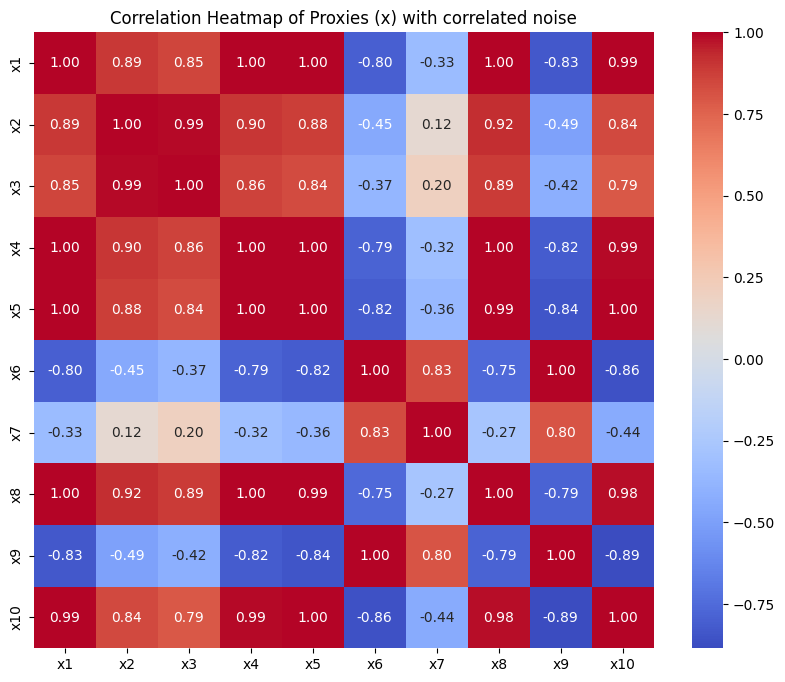

In [12]:
num_proxies = 10

non_linear_dataset = synthetic_dataset_non_linear(
    n = 2000,
    beta = 2.0,
    num_proxies = 10,
    shuffle_pct = 0.0,
    prior_type = "gaussian",
    sigma_x = 1.0,
    sigma_y = 1.0,
    rho = 0.99,   
    seed = 0,
)

x = non_linear_dataset['x']
y = non_linear_dataset['y']
t = non_linear_dataset['t']
z = non_linear_dataset['z']
ite = non_linear_dataset['ite']
# Convert x to a pandas DataFrame for correlation calculation
x_df = pd.DataFrame(x.numpy(), columns=[f'x{i+1}' for i in range(x.shape[1])])
corr_matrix = x_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Proxies (x) with correlated noise')
plt.show()

#### Shuffling

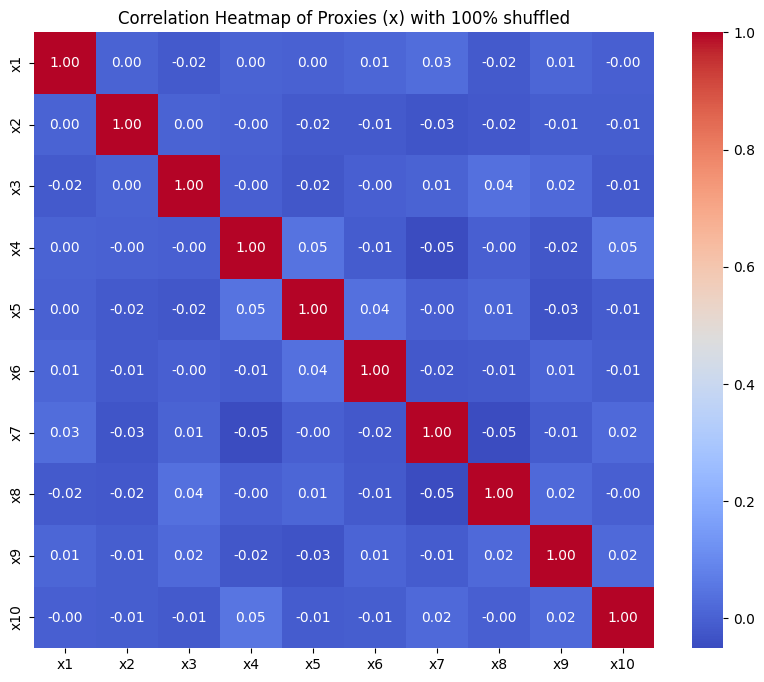

In [13]:
num_proxies = 10

non_linear_dataset = synthetic_dataset_non_linear(
    n = 2000,
    beta = 2.0,
    num_proxies = 10,
    shuffle_pct = 1.0,
    prior_type = "gaussian",
    sigma_x = 1.0,
    sigma_y = 1.0,
    rho = 0.0,   
    seed = 0,
)

x = non_linear_dataset['x']
y = non_linear_dataset['y']
t = non_linear_dataset['t']
z = non_linear_dataset['z']
ite = non_linear_dataset['ite']
# Convert x to a pandas DataFrame for correlation calculation
x_df = pd.DataFrame(x.numpy(), columns=[f'x{i+1}' for i in range(x.shape[1])])
corr_matrix = x_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Proxies (x) with 100% shuffled')
plt.show()

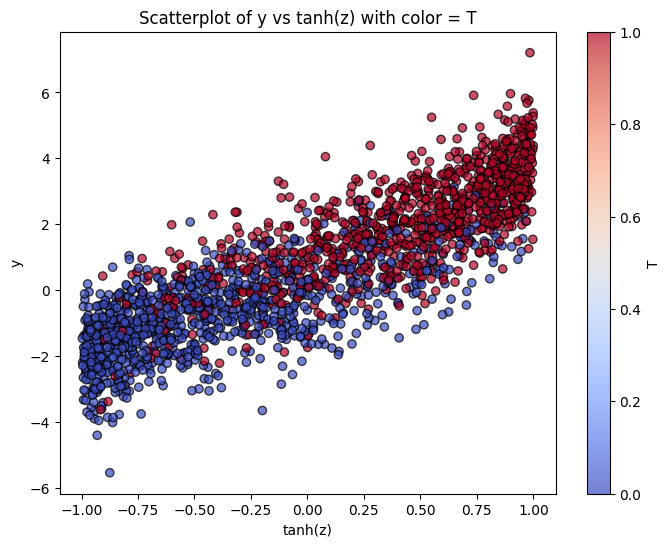

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Compute tanh(z)
tanh_z = np.tanh(z.numpy())

# Create scatterplot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(tanh_z, y.numpy(), c=t.numpy(), cmap='coolwarm', alpha=0.7, edgecolor='k')
plt.colorbar(scatter, label='T')
plt.xlabel('tanh(z)')
plt.ylabel('y')
plt.title('Scatterplot of y vs tanh(z) with color = T')
plt.show()

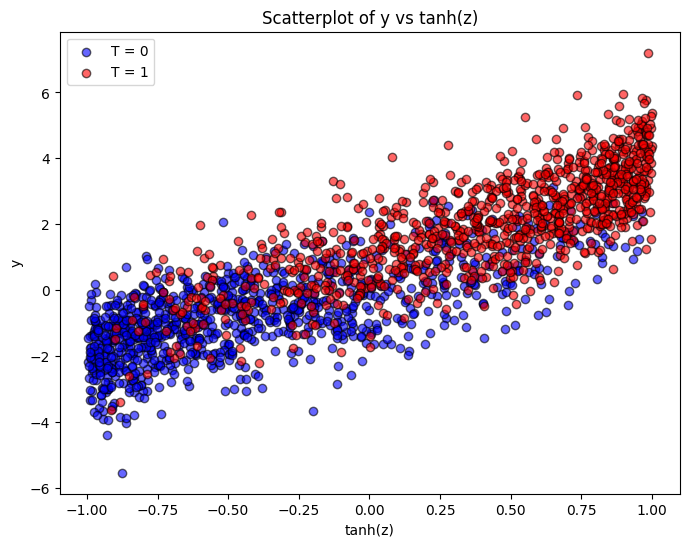

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Compute tanh(z)
tanh_z = np.tanh(z.numpy())
y_np = y.numpy()
t_np = t.numpy()

# Create scatterplot with separate plots for T=0 and T=1
plt.figure(figsize=(8, 6))

plt.scatter(tanh_z[t_np == 0], y_np[t_np == 0], color='blue', alpha=0.6, label='T = 0', edgecolor='k')
plt.scatter(tanh_z[t_np == 1], y_np[t_np == 1], color='red',  alpha=0.6, label='T = 1', edgecolor='k')

plt.xlabel('tanh(z)')
plt.ylabel('y')
plt.title('Scatterplot of y vs tanh(z)')
plt.legend()
plt.show()


#### Increasing the confounding strenght

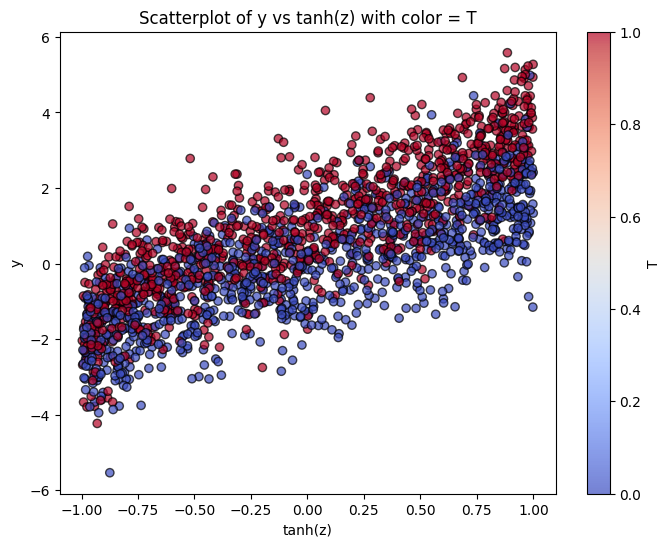

In [16]:
num_proxies = 10

non_linear_dataset = synthetic_dataset_non_linear(
    n = 2000,
    beta = 0.0,
    num_proxies = 10,
    shuffle_pct = 1.0,
    prior_type = "gaussian",
    sigma_x = 1.0,
    sigma_y = 1.0,
    rho = 0.0,   
    seed = 0,
)

x = non_linear_dataset['x']
y = non_linear_dataset['y']
t = non_linear_dataset['t']
z = non_linear_dataset['z']
ite = non_linear_dataset['ite']

tanh_z = np.tanh(z.numpy())

# Create scatterplot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(tanh_z, y.numpy(), c=t.numpy(), cmap='coolwarm', alpha=0.7, edgecolor='k')
plt.colorbar(scatter, label='T')
plt.xlabel('tanh(z)')
plt.ylabel('y')
plt.title('Scatterplot of y vs tanh(z) with color = T')
plt.show()

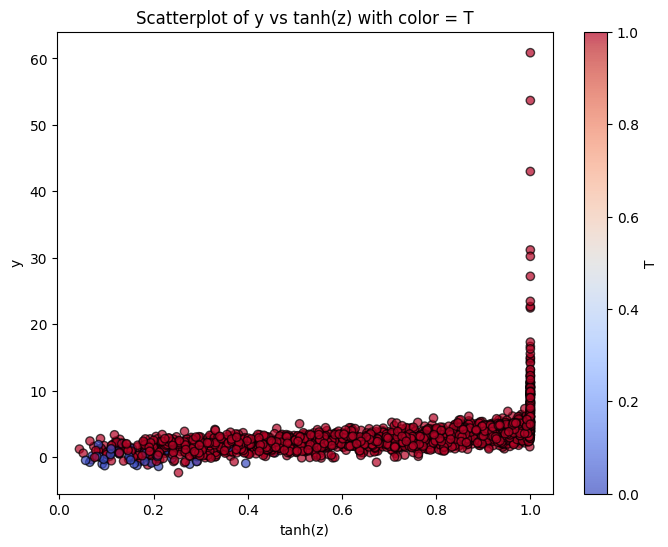

In [17]:
num_proxies = 10

non_linear_dataset = synthetic_dataset_non_linear(
    n = 2000,
    beta = 10.0,
    num_proxies = 10,
    shuffle_pct = 1.0,
    prior_type = "lognormal",
    sigma_x = 1.0,
    sigma_y = 1.0,
    rho = 0.0,   
    seed = 0,
)

x = non_linear_dataset['x']
y = non_linear_dataset['y']
t = non_linear_dataset['t']
z = non_linear_dataset['z']
ite = non_linear_dataset['ite']

tanh_z = np.tanh(z.numpy())

# Create scatterplot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(tanh_z, y.numpy(), c=t.numpy(), cmap='coolwarm', alpha=0.7, edgecolor='k')
plt.colorbar(scatter, label='T')
plt.xlabel('tanh(z)')
plt.ylabel('y')
plt.title('Scatterplot of y vs tanh(z) with color = T')
plt.show()

### Outcome as Viewed from the Proxies POV

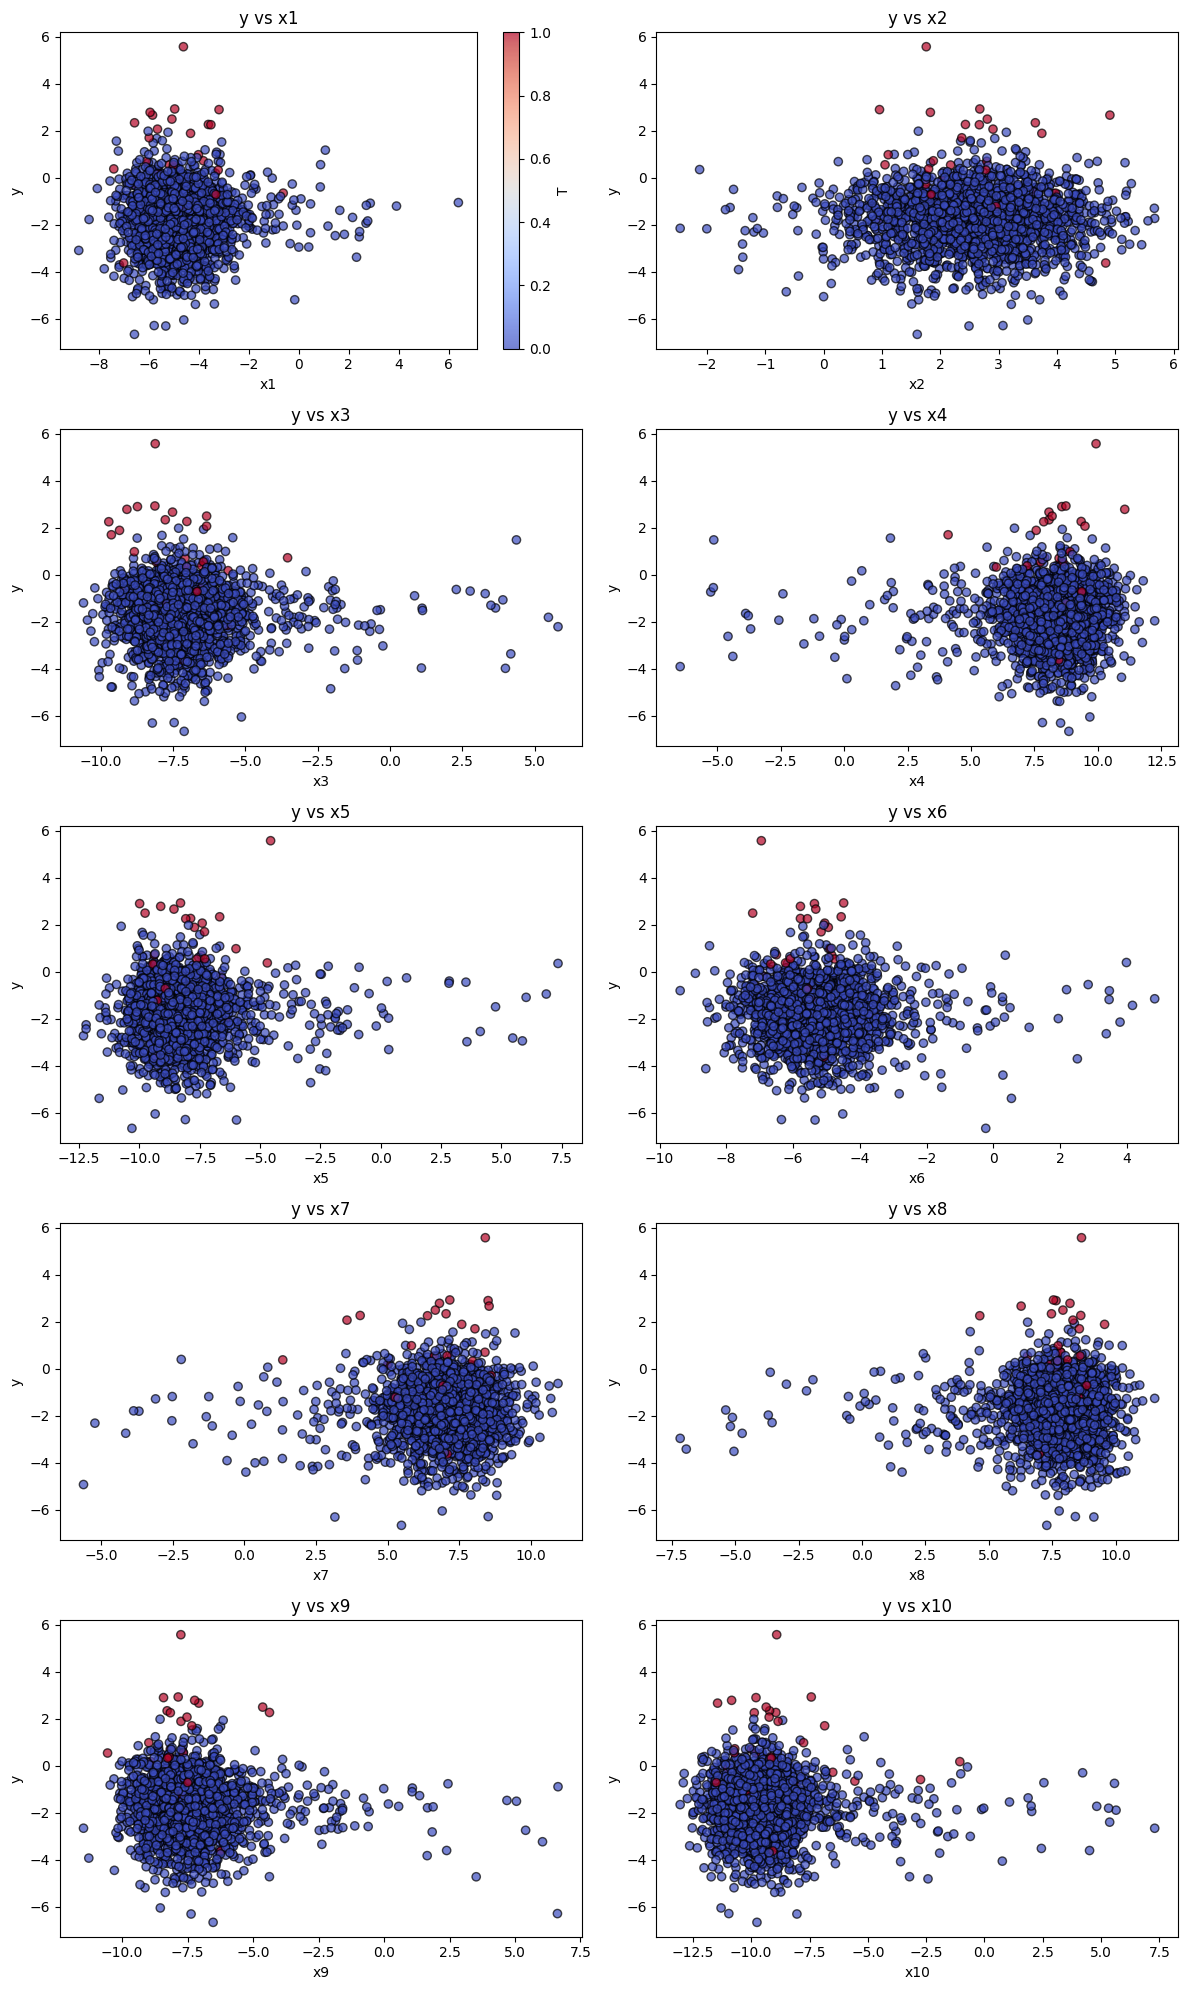

In [18]:
num_proxies = 10

non_linear_dataset = synthetic_dataset_non_linear(
    n = 2000,
    beta = 4.0,
    num_proxies = 10,
    shuffle_pct = 1.0,
    prior_type = "bimodal",
    sigma_x = 1.0,
    sigma_y = 1.0,
    rho = 0.0,   
    seed = 0,
)

x = non_linear_dataset['x']
y = non_linear_dataset['y']
t = non_linear_dataset['t']
z = non_linear_dataset['z']
ite = non_linear_dataset['ite']

# Set up the grid for subplots
ncols = 2
nrows = int(np.ceil(num_proxies / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(12, 4 * nrows))
axes = axes.flatten()

# Create scatterplots for each proxy
for i in range(num_proxies):
    ax = axes[i]
    scatter = ax.scatter(x[:, i].numpy(), y.numpy(), c=t.numpy(), cmap='coolwarm', alpha=0.7, edgecolor='k')
    ax.set_xlabel(f'x{i+1}')
    ax.set_ylabel('y')
    ax.set_title(f'y vs x{i+1}')
    if i == 0:  # Add colorbar to the first plot
        cbar = fig.colorbar(scatter, ax=ax, orientation='vertical')
        cbar.set_label('T')

# Hide any unused subplots
for i in range(num_proxies, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()